# Location scale regression with smooth covariates 

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os 

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

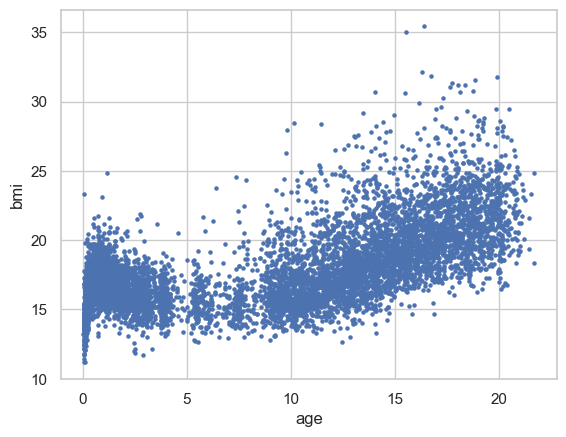

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# Define a model with intercept 
# Set up design matrix for loc
X = tiger.Obs(name="X", intercept=True)
X.smooth(data=df["age"].to_numpy(), n_knots=20)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Set up design matrix for scale 
Z = tiger.Obs(name="Z", intercept=True)
Z.smooth(data=df["age"].to_numpy(), n_knots=20)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
Z.center()

# Linear Predictor for the location ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=jnp.zeros((1,)), distribution=beta_dist, name="beta")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
smooth1_tau2_a = tiger.Hyper(1.0, name="smooth1_tau2_a")
smooth1_tau2_b = tiger.Hyper(0.00005, name="smooth1_tau2_b")
smooth1_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth1_tau2_a, scale=smooth1_tau2_b)
smooth1_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth1_tau2_dist, param_space="positive", name="smooth1_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth1_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="smooth1_loc")
smooth1_pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="smooth1_pen")
# Set up parameters
smooth1_dist = tiger.Dist(MultivariateNormalDegenerate, loc=smooth1_loc, var=smooth1_tau2, pen=smooth1_pen)
smooth1 = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=smooth1_dist, name="smooth1")

# Set up the linear predictor
lpred_loc = tiger.Lpred(obs=X, beta_fixed=beta, beta_smooth=smooth1)

# Linear Predictor for the scale ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(3.0, name="gamma_scale")

# Set up parameters
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=jnp.zeros(1,), distribution=gamma_dist, name="gamma")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
smooth2_tau2_a = tiger.Hyper(1.0, name="smooth2_tau2_a")
smooth2_tau2_b = tiger.Hyper(0.00005, name="smooth2_tau2_b")
smooth2_tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=smooth2_tau2_a, scale=smooth2_tau2_b)
smooth2_tau2 = tiger.Param(value=jnp.array([1.0]), distribution=smooth2_tau2_dist, param_space="positive", name="smooth2_tau2")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
smooth2_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[0]), name="smooth2_loc")
smooth2_pen = tiger.Hyper(Z.smooth_pen_mat_cent[0], name="smooth2_pen")
# Set up parameters
smooth2_dist = tiger.Dist(MultivariateNormalDegenerate, loc=smooth2_loc, var=smooth2_tau2, pen=smooth2_pen)
smooth2 = tiger.Param(value=np.zeros(Z.smooth_dim_cent[0]), distribution=smooth2_dist, name="smooth2")

# ----
# Set up the linear predictor
lpred_scale = tiger.Lpred(obs=Z, gamma_fixed=gamma, gamma_smooth=smooth2, function=jnp.exp)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [4]:
m.log_prob

Array(-1222732.5, dtype=float32)

In [5]:
m.log_prior

Array(-56.58656, dtype=float32)

In [6]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [7]:
graph.sum_logpriors()

Array(-56.58656, dtype=float32)

In [8]:
graph.logprob()

Array(-1222732.5, dtype=float32)

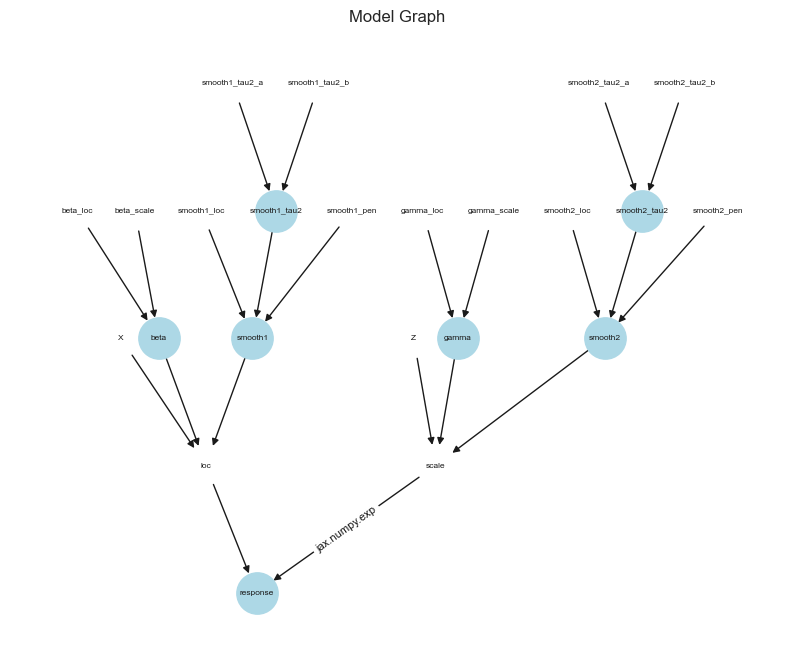

In [9]:
graph.visualize_graph()

## Inference with Bbvi

In [11]:
q = bbvi.Bbvi(graph=graph,
              pre_train=True,
              loc_prec=1.0,
              scale_prec=2.0)

In [12]:
q.run_bbvi(key=jax.random.PRNGKey(42),
           learning_rate=0.01,
           pre_train_learning_rate=0.01,
           grad_clip=1,
           threshold=1e-1,
           pre_train_threshold=1e-1,
           batch_size=128,
           pre_train_batch_size=128,
           train_share=0.8,
           num_var_samples=64,
           chunk_size=50,
           epochs=250)

Start pre-training ...
Finished pre-training
Start optimization ...
Finished optimization


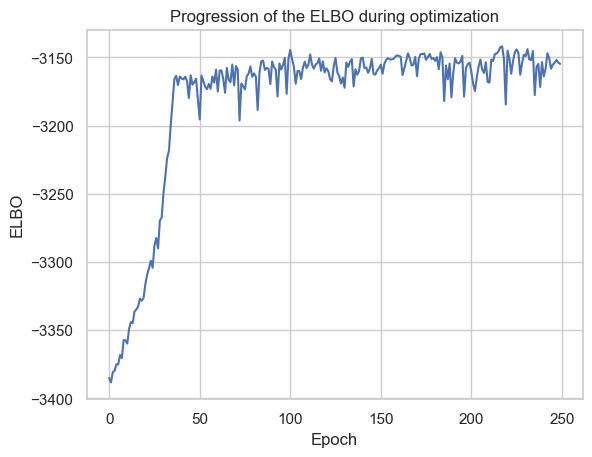

In [13]:
q.plot_elbo()

## Visualize the regression line 

In [14]:
q.return_loc_params

{'beta': {'loc': Array([18.042095], dtype=float32)},
 'smooth1_tau2': {'loc': Array([0.669676], dtype=float32)},
 'gamma': {'loc': Array([0.672328], dtype=float32)},
 'smooth2_tau2': {'loc': Array([0.00678733], dtype=float32)},
 'smooth1': {'loc': Array([-2.6153598 , -2.656357  , -1.864465  , -2.4325798 , -2.5453742 ,
         -2.034941  , -1.6238542 , -1.4533505 , -1.0080687 , -0.58392745,
         -0.2300542 ,  0.33020067,  1.1068448 ,  1.543931  ,  2.0133388 ,
          2.6265159 ,  3.6246135 ,  3.8072958 ,  3.8220608 ], dtype=float32)},
 'smooth2': {'loc': Array([-0.49969372, -0.27174672, -0.4071478 , -0.39394593, -0.33067048,
         -0.19761209, -0.0613754 ,  0.06238318,  0.12068178,  0.15361457,
          0.19062847,  0.23640901,  0.2872376 ,  0.24187717,  0.19938289,
          0.25895086,  0.367704  ,  0.37945497,  0.39424405], dtype=float32)}}

In [15]:
b = q.trans_var_params["beta"]["loc"]
g = q.trans_var_params["smooth1"]["loc"]

In [16]:
# Location
# for fixed and smooth terms
beta_post = q.trans_var_params["beta"]["loc"]
smooth1_post = q.trans_var_params["smooth1"]["loc"]
loc_post = jnp.concatenate((beta_post, smooth1_post))
y_loc = X.design_matrix @ loc_post
# Scale 
gamma_post = q.trans_var_params["gamma"]["loc"]
smooth2_post = q.trans_var_params["smooth2"]["loc"]
scale_post = jnp.concatenate((gamma_post, smooth2_post))
y_scale = jnp.exp(Z.design_matrix @ scale_post)

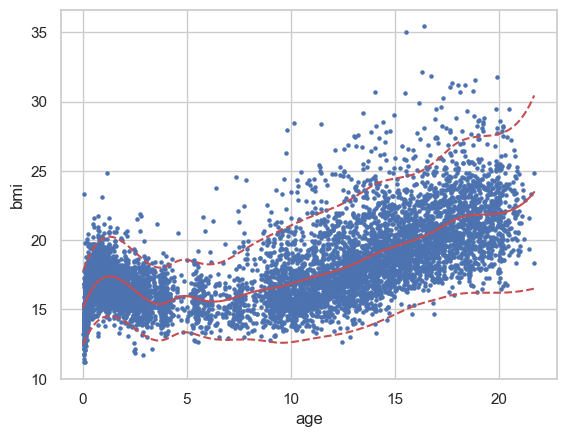

In [17]:
# plot the data
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y_loc, color = "r")
ax.plot(df["age"].to_numpy(), y_loc - 1.96*y_scale, color = "r", linestyle="--")
ax.plot(df["age"].to_numpy(), y_loc + 1.96*y_scale, color = "r", linestyle="--")
plt.show()

In [18]:
tau2 = q.trans_var_params["smooth1_tau2"]["loc"]
eta2 = q.trans_var_params["smooth2_tau2"]["loc"]

In [19]:
1/tau2

Array([1.4932594], dtype=float32)

In [20]:
1/eta2

Array([147.33342], dtype=float32)